<a href="https://colab.research.google.com/github/tenorio74/machine_learning/blob/main/Pokemon_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokemon GANS 

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import PIL
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import imageio
import time
from IPython import display

Using TensorFlow backend.


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Preprocessing

In [ ]:
import os
import zipfile
# Extract Data from google drive
local_zip = '/content/drive/My Drive/Colab Notebooks/gan_train_pokemon.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

NOTE Google Colaboratory will allow a maximum resultion of 128 x 128, unless you purchase more run time. 

In [ ]:

GENERATE_RES =4 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


In [ ]:
from pathlib import Path
from keras.preprocessing import image
import glob

# dirs = p.glob('*')
image_data = []


start = time.time()
# load images to array
for img_path in glob.glob('/tmp/gan_train_pokemon/*.jpg'):
  img = image.load_img(img_path, target_size=(GENERATE_SQUARE,GENERATE_SQUARE,Image.ANTIALIAS))
  img_array = image.img_to_array(img)
  image_data.append(img_array)

#Convert Image Array to NP Array
training_data = np.array(image_data)
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.
elapsed = time.time()- start
print("The are a total of "+ str(len(training_data))+" pokemon images")
print("Image processing time is: "+hms_string(elapsed))

The are a total of 819 pokemon images
Image processing time is: 0:00:12.76


490


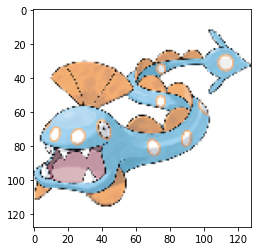

413


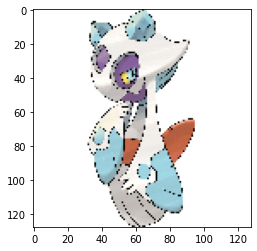

810


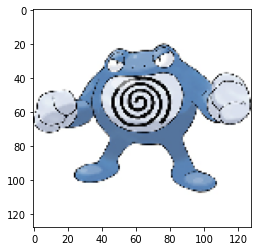

726


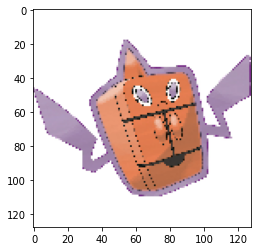

261


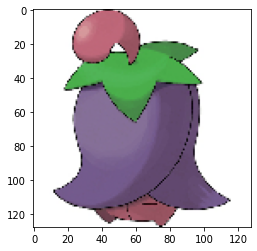

In [ ]:
# plot some of our training pokemon
def viewImg(img):
  plt.imshow(img)
  plt.show()
X = np.array(image_data)
# plot 5 random pokemon
for i in range(5):
  r = np.random.randint(819)
  print(r)
  viewImg(X[r]/255.)

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Models

In [ ]:

def make_generator_model(seed,channels):
    #First Convolution, Batch Normalization, Activation
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(seed,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)

    #Second Convolution, Batch Nomalization, Activation
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Third Convloution, Batch Normalizaiton, Activation
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Fourth Convolution, Batch Normalization, Activation
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Fifth Convolution, Batch Normalization, Activation
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Last Covolution for output
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

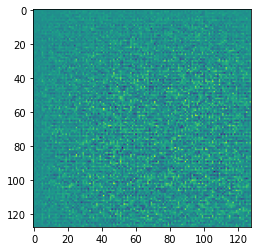

In [ ]:
generator = make_generator_model(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
def make_discriminator_model(image_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=image_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = make_discriminator_model(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-3.4016004e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-3)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/Fake_Pokemon'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.jpg'.format(epoch))
  plt.show()


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {}. '.format(epoch + 1, hms_string(time.time()-start)))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

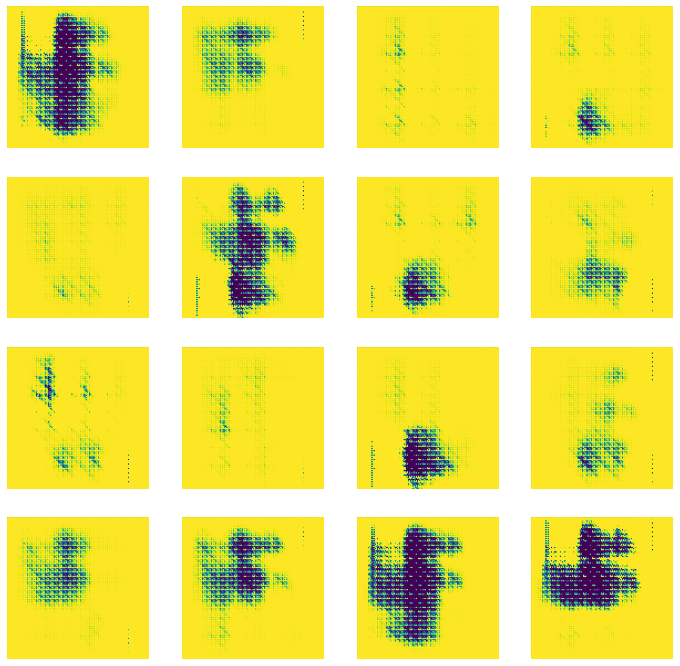

Time for epoch 445 is 0:00:08.38. 


In [ ]:
# Training for the 1st time epochs 1-500
overall_start = time.time()
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 2nd time epochs 501-600
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 3rd time epochs 601-1000
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))
 

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 4th time epochs 1001-1500
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 5th time epochs 1501-2000
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 6th time epochs 2001-2500
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 7th time epochs 2501-3000
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 8th time epochs 3001-3500
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 9th time epochs 3501-4000
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 10th time epochs 4001-4500
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 11th time epochs 4501-5000
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Training for the 12th time epochs 5001-5500
start = time.time()
train(train_dataset, EPOCHS)
elapsed = time.time()-start
print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 13th time epochs 5501-6000
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 14th time epochs 6001-6500
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 15th time epochs 6501-7000
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 16th time epochs 7001-7500
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 17th time epochs 7501-8000
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 18th time epochs 8001-8500
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# # Training for the 19th time epochs 8501-9000
# start = time.time()
# train(train_dataset, EPOCHS)
# elapsed = time.time()-start
# print("Total Training time: "+hms_string(elapsed))

In [ ]:
total_training_time = time.time() - overall_start
print("The entire training time: " + hms_string(total_training_time))

## View New Image

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.jpg'.format(epoch_no))

display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.jpg')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)